In [3]:
import pandas as pd
import numpy as np
import pickle
import zipfile
import os
from biosppy.signals import ecg
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [4]:
def load_pkl(subject_id):
    file_path = f"WESAD/{subject_id}/{subject_id}.pkl"
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding = 'latin1')
    return data

subject_ids = [f"S{i}" for i in range(2, 18)]

all_data = {}
for subject_id in subject_ids:
    if os.path.exists(f"WESAD/{subject_id}/{subject_id}.pkl"):
        all_data[subject_id] = load_pkl(subject_id)
    else:
        print(f"Data for {subject_id} not found!")
        
s2_data = all_data["S2"]

Data for S12 not found!


In [5]:
unique_labels = np.unique(s2_data['label'])
print(unique_labels)

[0 1 2 3 4 6 7]


In [6]:
def get_data_size(subject_data, device, signal_type):
    """Returns the size of the specified dataset for the subject."""
    return len(subject_data['signal'][device][signal_type])

for subject_id, data in all_data.items():
    print(f"\nSubject: {subject_id}")
    for device in ['chest', 'wrist']:
        print(f"\tDevice: {device}")
        
        for signal_type in data['signal'][device]:
            size = get_data_size(data, device, signal_type)
            print(f"\t\tSignal type: {signal_type}, Size: {size}")


Subject: S2
	Device: chest
		Signal type: ACC, Size: 4255300
		Signal type: ECG, Size: 4255300
		Signal type: EMG, Size: 4255300
		Signal type: EDA, Size: 4255300
		Signal type: Temp, Size: 4255300
		Signal type: Resp, Size: 4255300
	Device: wrist
		Signal type: ACC, Size: 194528
		Signal type: BVP, Size: 389056
		Signal type: EDA, Size: 24316
		Signal type: TEMP, Size: 24316

Subject: S3
	Device: chest
		Signal type: ACC, Size: 4545100
		Signal type: ECG, Size: 4545100
		Signal type: EMG, Size: 4545100
		Signal type: EDA, Size: 4545100
		Signal type: Temp, Size: 4545100
		Signal type: Resp, Size: 4545100
	Device: wrist
		Signal type: ACC, Size: 207776
		Signal type: BVP, Size: 415552
		Signal type: EDA, Size: 25972
		Signal type: TEMP, Size: 25972

Subject: S4
	Device: chest
		Signal type: ACC, Size: 4496100
		Signal type: ECG, Size: 4496100
		Signal type: EMG, Size: 4496100
		Signal type: EDA, Size: 4496100
		Signal type: Temp, Size: 4496100
		Signal type: Resp, Size: 4496100
	Devic

In [7]:
def filter_signals(data):
    data['signal']['chest'] = {'ECG': data['signal']['chest']['ECG']}
    
    wrist_keys_to_keep = ['EDA', 'TEMP']
    data['signal']['wrist'] = {key: data['signal']['wrist'][key] for key in wrist_keys_to_keep}
    
    return data

for subject, subject_data in all_data.items():
    all_data[subject] = filter_signals(subject_data)

In [8]:
all_data

{'S2': {'signal': {'chest': {'ECG': array([[ 0.02142334],
           [ 0.02032471],
           [ 0.01652527],
           ...,
           [-0.00544739],
           [ 0.00013733],
           [ 0.0040741 ]])},
   'wrist': {'EDA': array([[1.138257],
           [1.125444],
           [1.011405],
           ...,
           [0.059208],
           [0.073303],
           [0.045113]]),
    'TEMP': array([[35.41],
           [35.41],
           [35.41],
           ...,
           [34.23],
           [34.23],
           [34.23]])}},
  'label': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
  'subject': 'S2'},
 'S3': {'signal': {'chest': {'ECG': array([[-0.75663757],
           [-0.70820618],
           [-0.67396545],
           ...,
           [-0.24847412],
           [-0.18598938],
           [-0.14176941]])},
   'wrist': {'EDA': array([[2.248749],
           [2.710001],
           [2.554969],
           ...,
           [0.301362],
           [0.301362],
           [0.301362]]),
    'TEMP': array(

In [9]:
def transform_and_resample(subject_data):
    ecg_df = pd.DataFrame(subject_data['signal']['chest']['ECG'], columns = ['ECG'])
    
    temp_stretched = np.repeat(subject_data['signal']['wrist']['TEMP'], 175)
    eda_stretched = np.repeat(subject_data['signal']['wrist']['EDA'], 175)
    
    temp_df = pd.DataFrame(temp_stretched, columns = ['TEMP'])
    eda_df = pd.DataFrame(eda_stretched, columns = ['EDA'])
    
    merged_df = pd.concat([ecg_df, temp_df, eda_df], axis=1)
    
    merged_df['label'] = subject_data['label']
    merged_df['subject'] = subject_data['subject']
    
    return merged_df

dfs = []
for subject, subject_data in all_data.items():
    dfs.append(transform_and_resample(subject_data))

In [10]:
df = dfs[0]

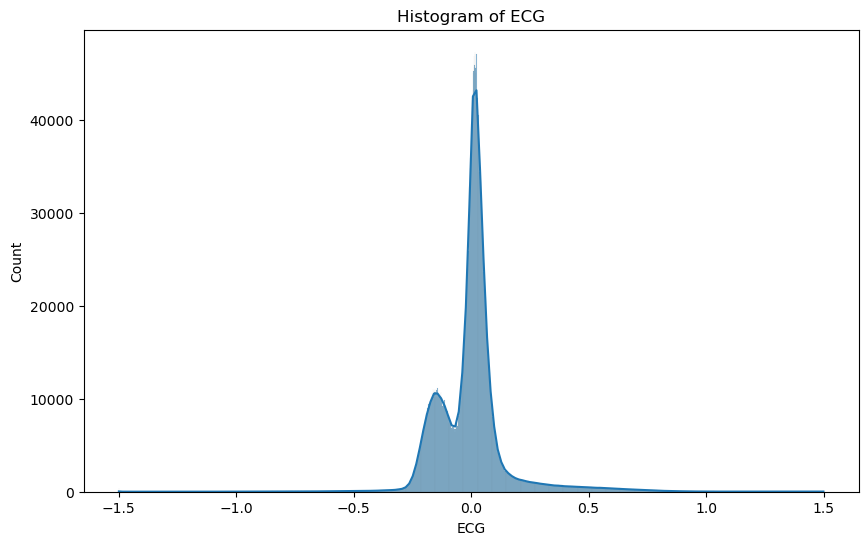

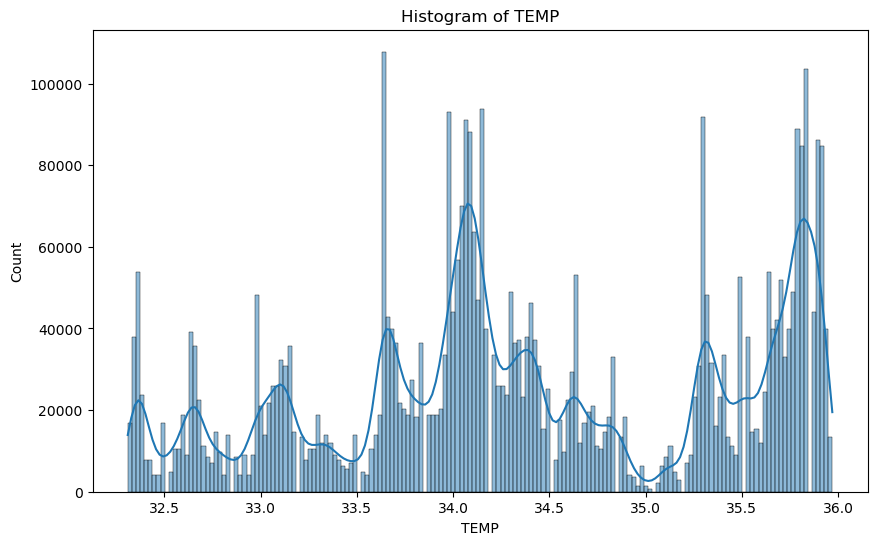

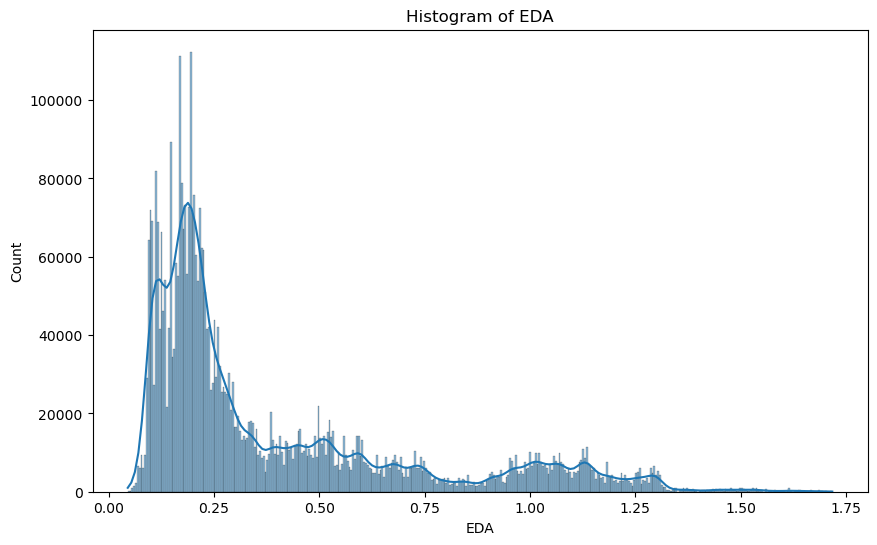

/var/folders/kb/fxsdzvkd3tn7qtds435g0l880000gn/T/ipykernel_90841/1010653668.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby('label').mean()


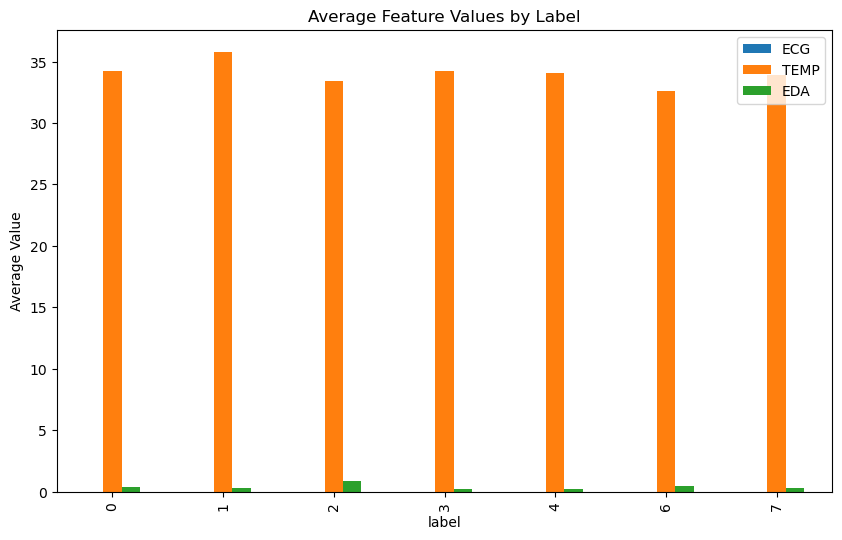

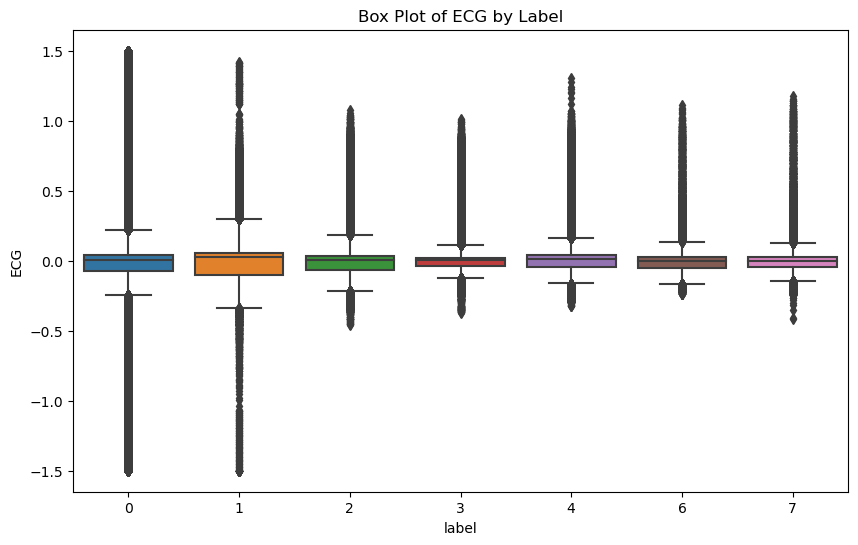

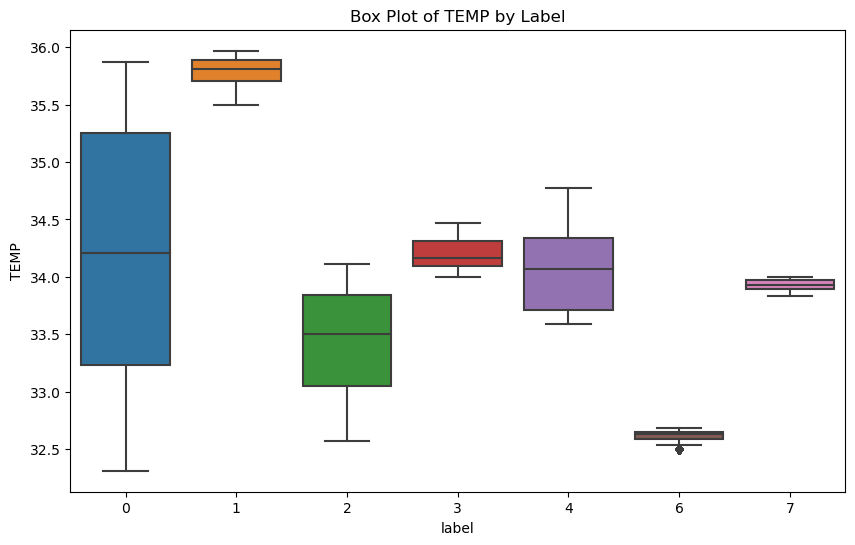

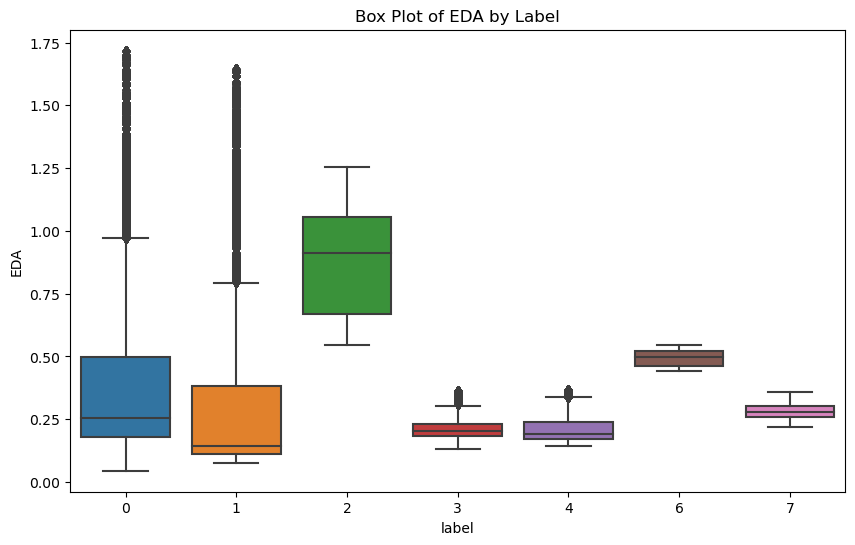

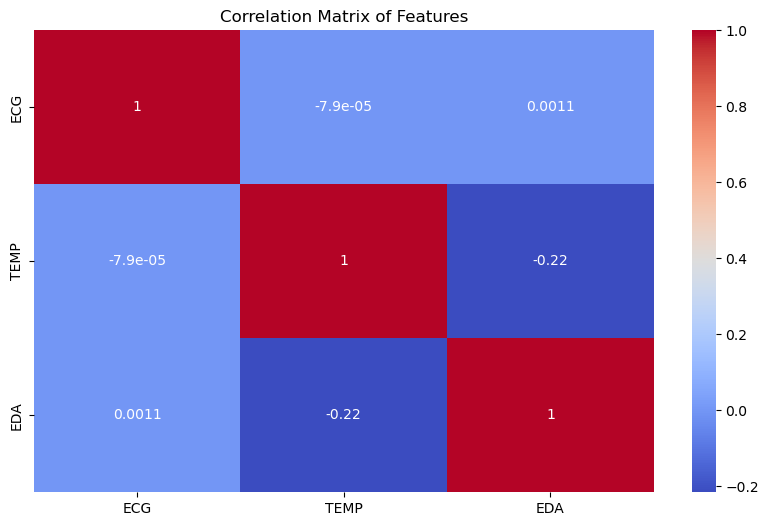

In [11]:
# Histograms for each feature
features = ["ECG", "TEMP", "EDA"]
for feature in features:
    plt.figure(figsize=(10,6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    plt.show()

# Average values of features by label
grouped = df.groupby('label').mean()
grouped[features].plot(kind='bar', figsize=(10,6))
plt.title('Average Feature Values by Label')
plt.ylabel('Average Value')
plt.show()

# Box plots for each feature by label
for feature in features:
    plt.figure(figsize=(10,6))
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Box Plot of {feature} by Label')
    plt.show()

# Correlation matrix
correlation_matrix = df[features].corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

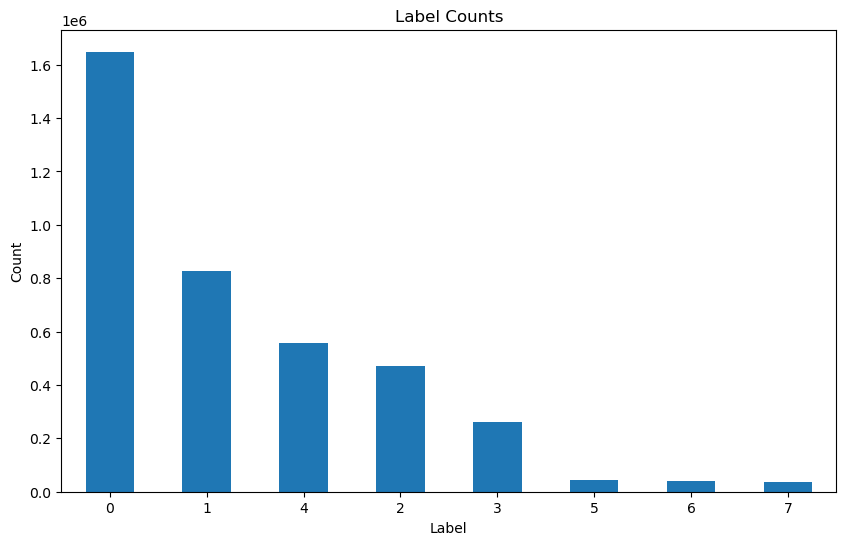

In [12]:
import matplotlib.pyplot as plt

# Get label counts
label_counts = dfs[11]['label'].value_counts()

# Plot label counts
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0) # Keeps the x-axis labels from rotating
plt.show()

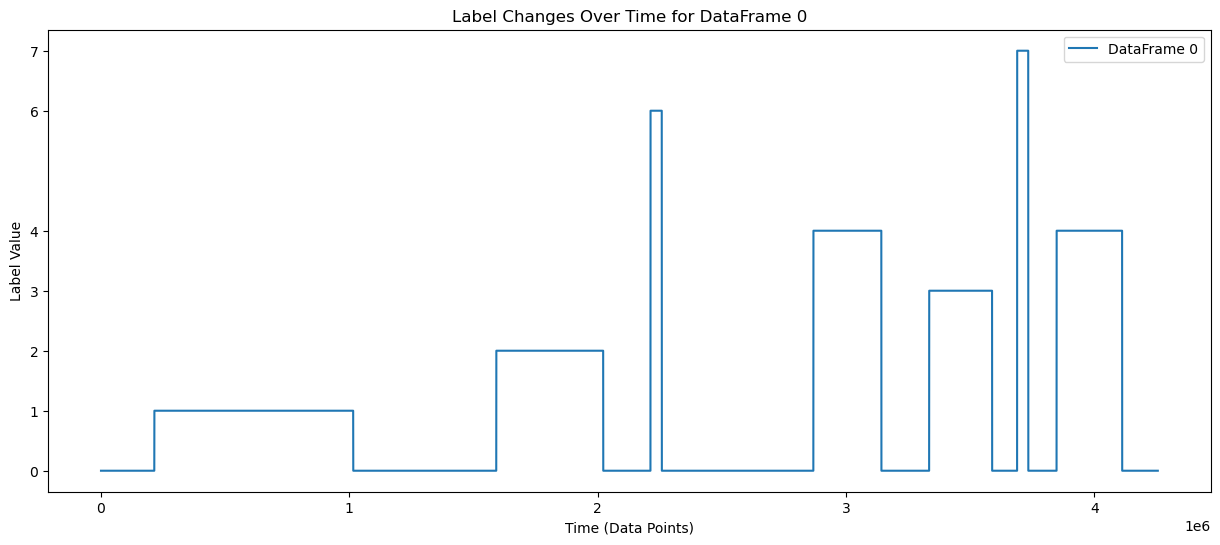

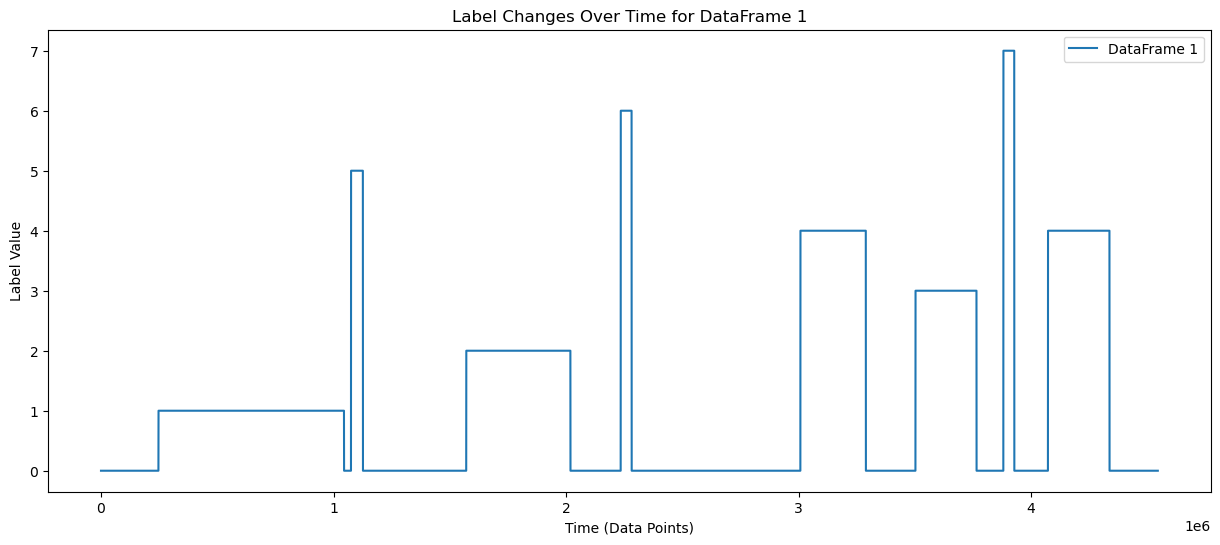

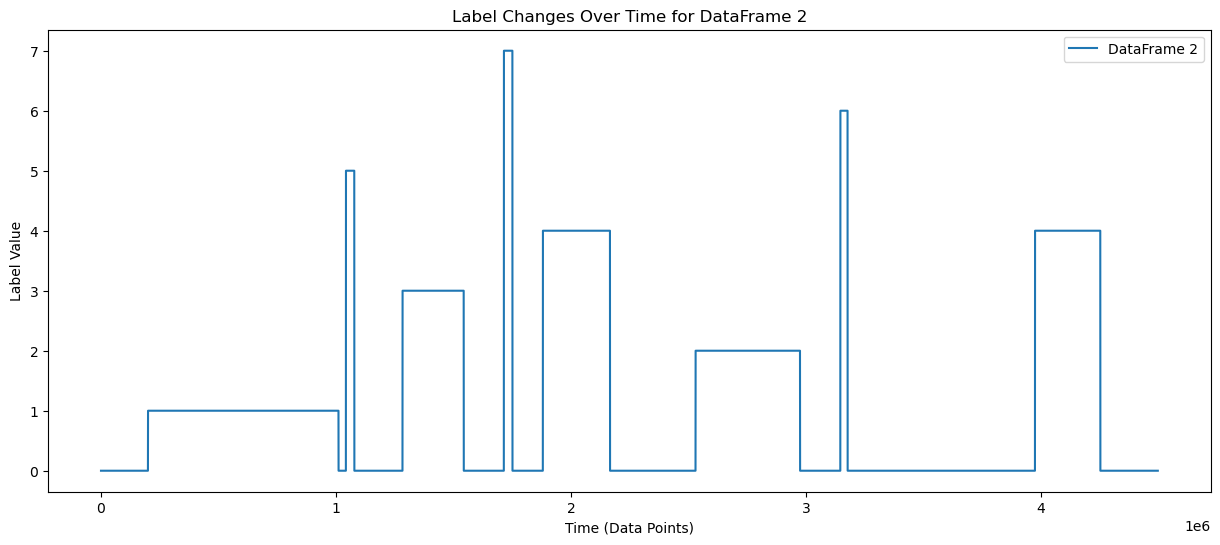

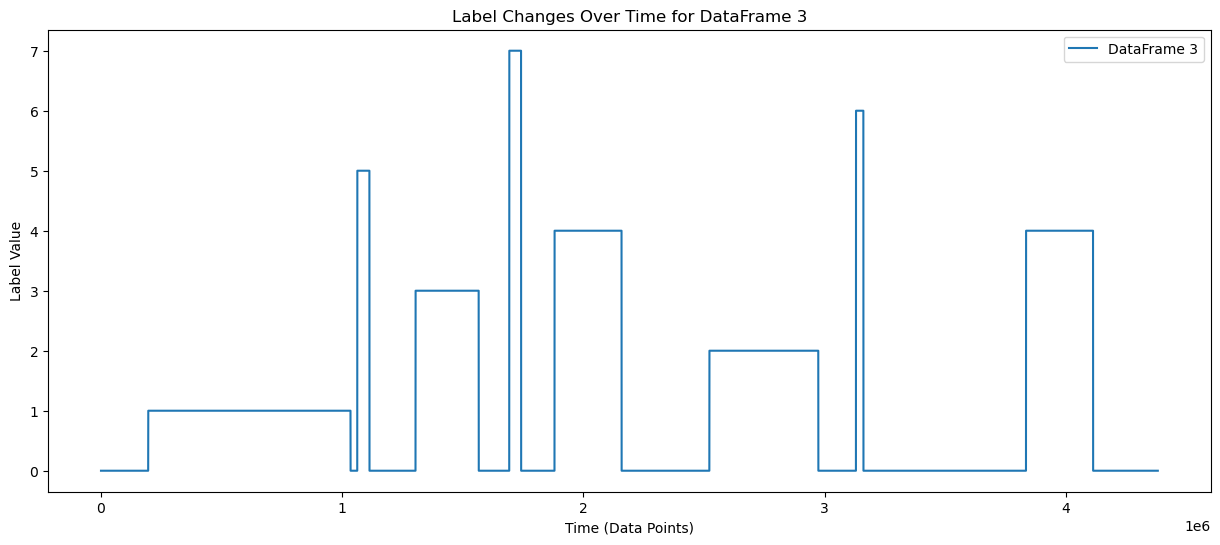

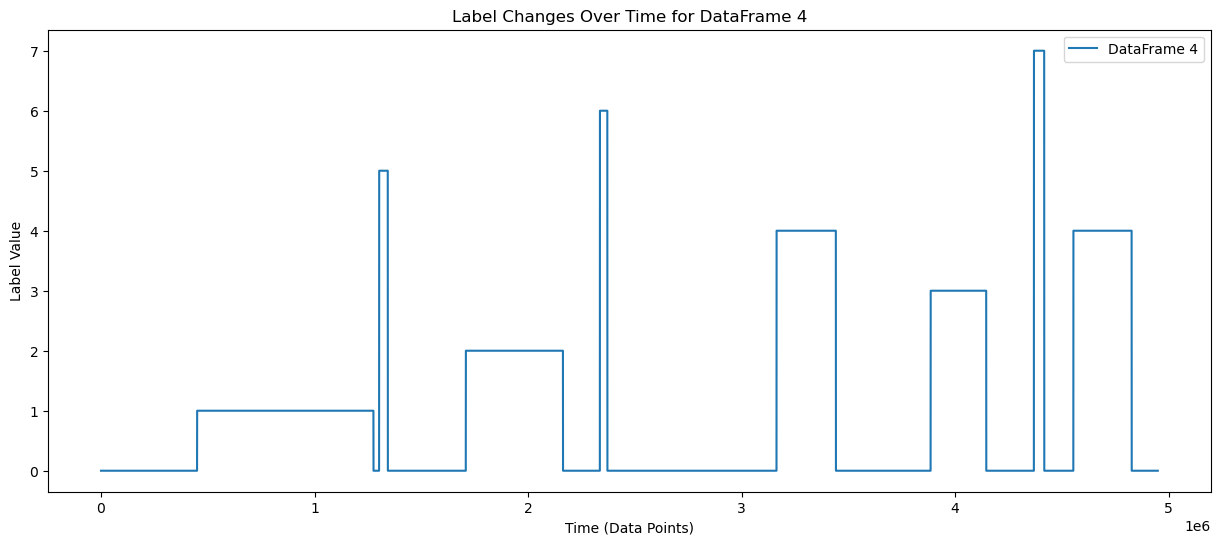

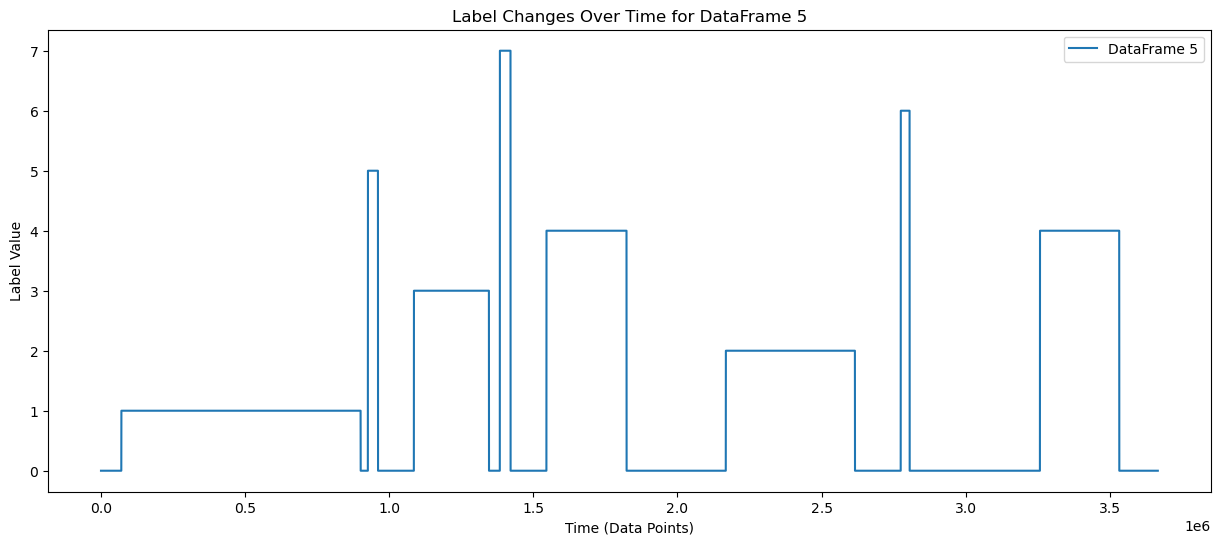

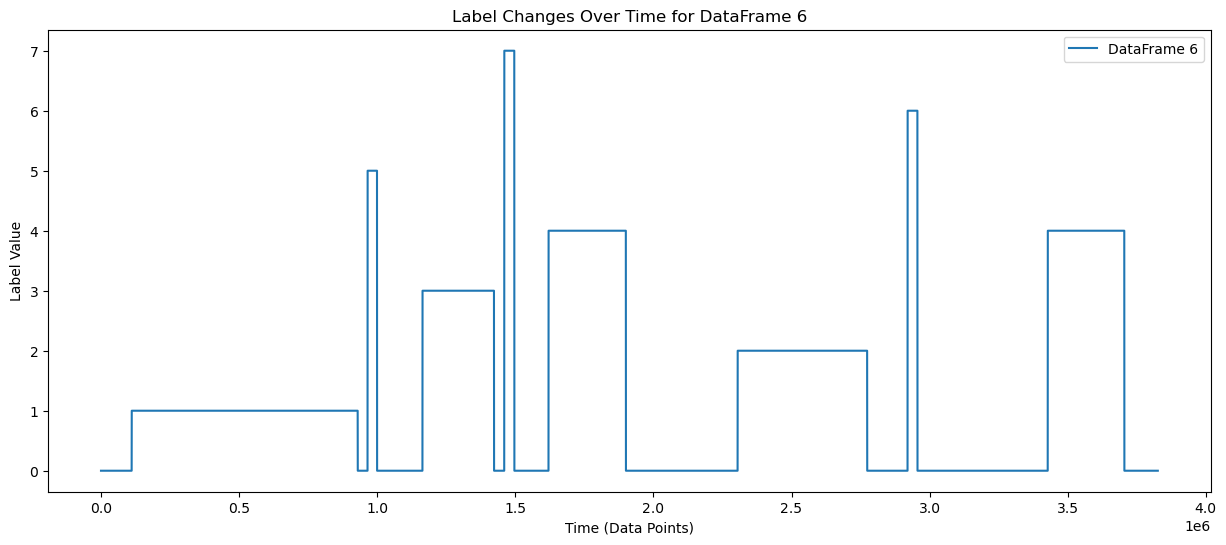

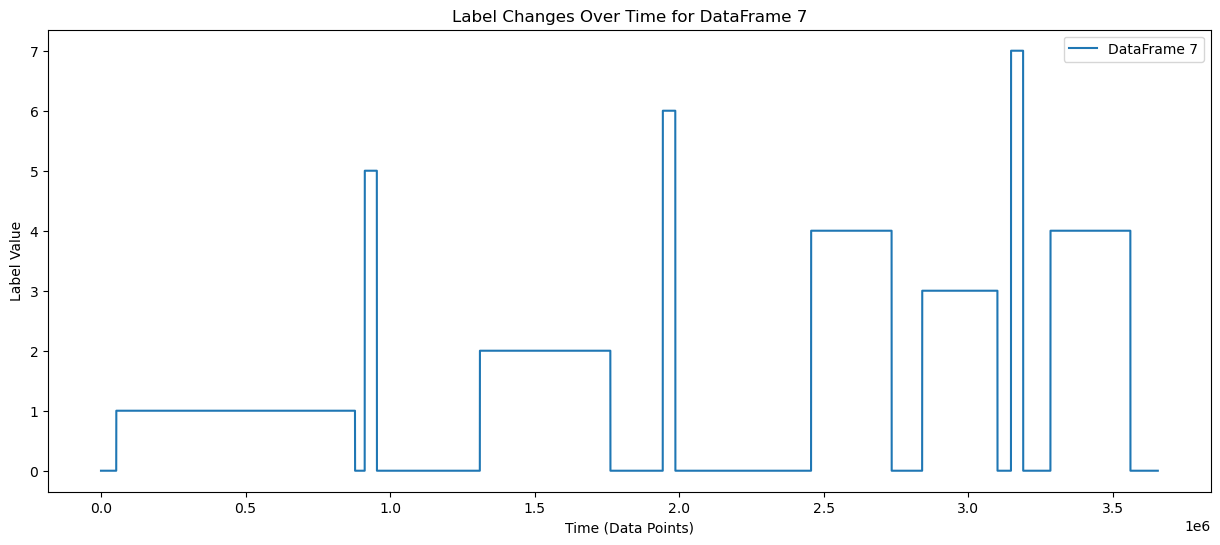

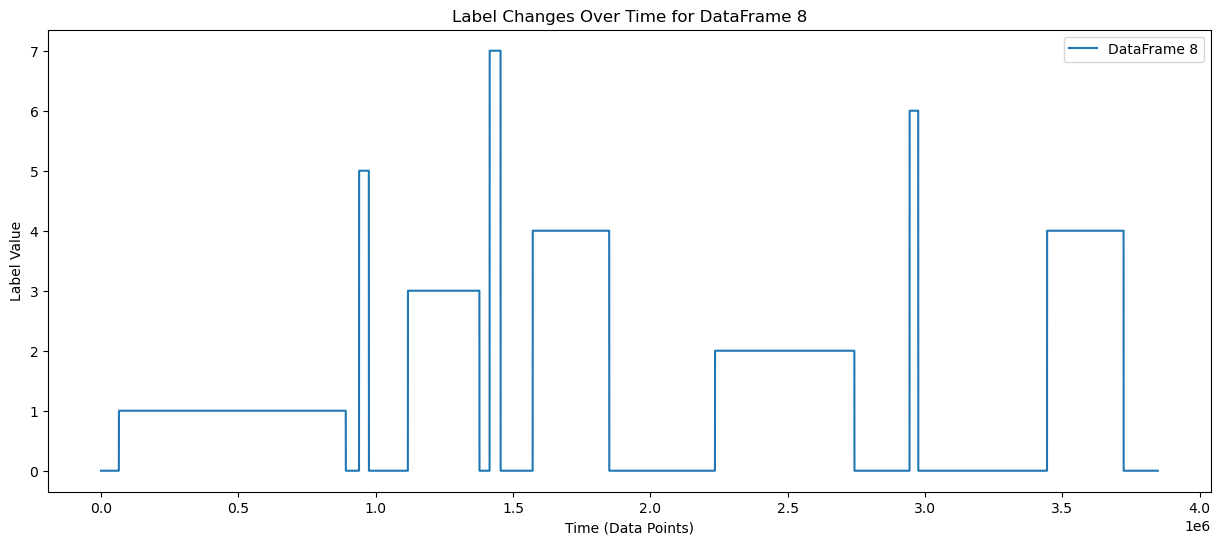

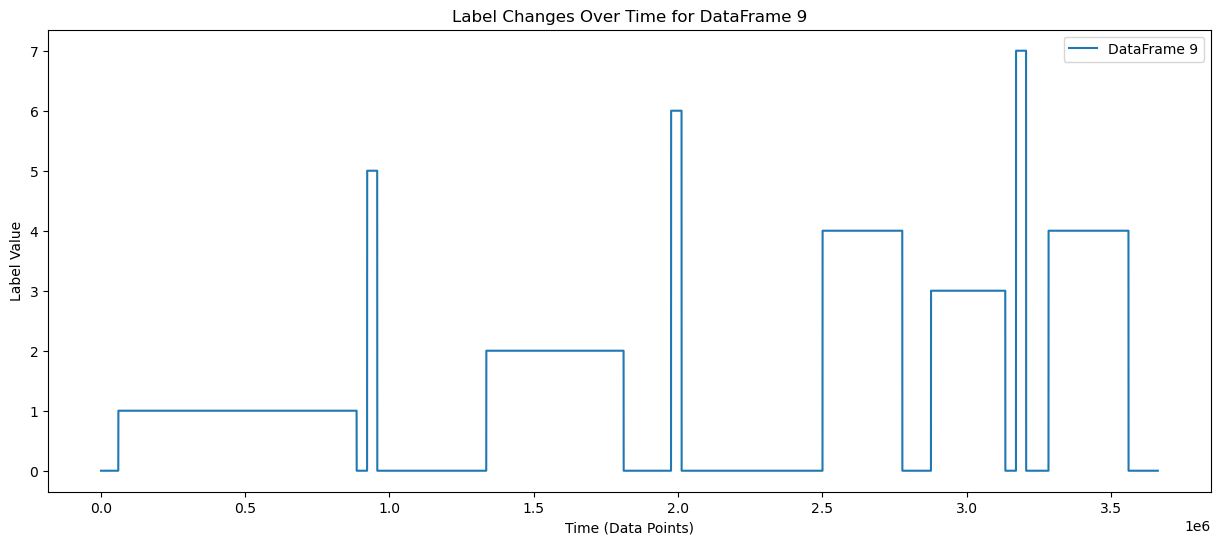

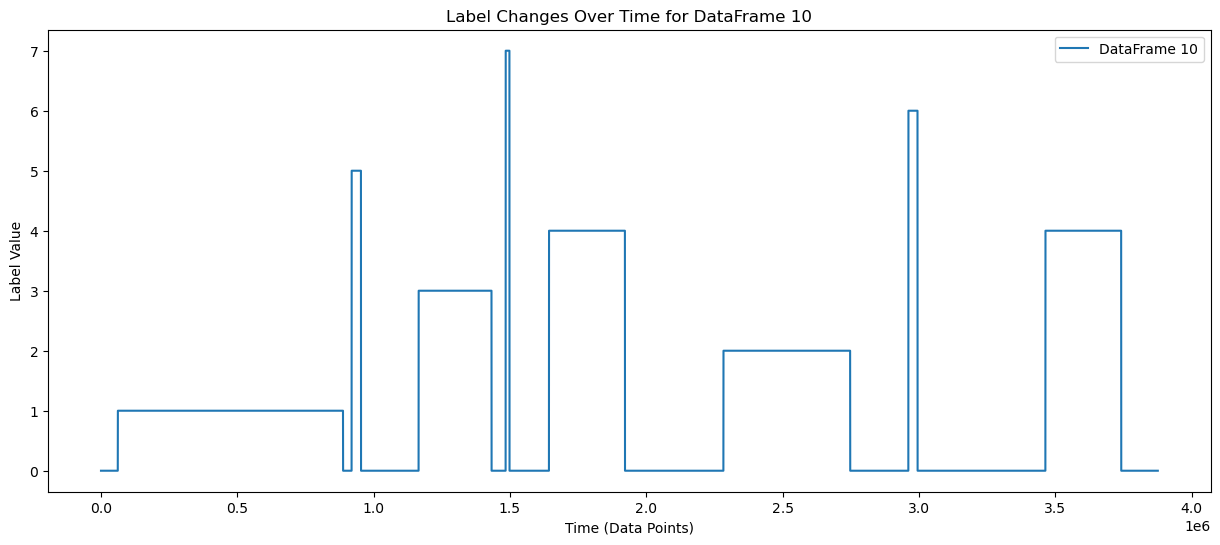

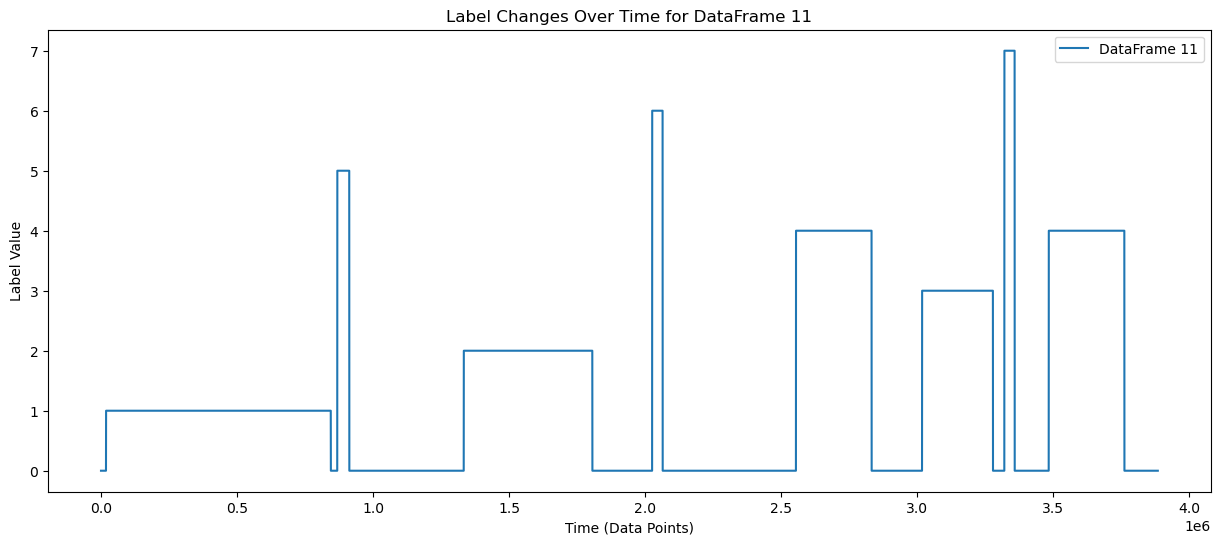

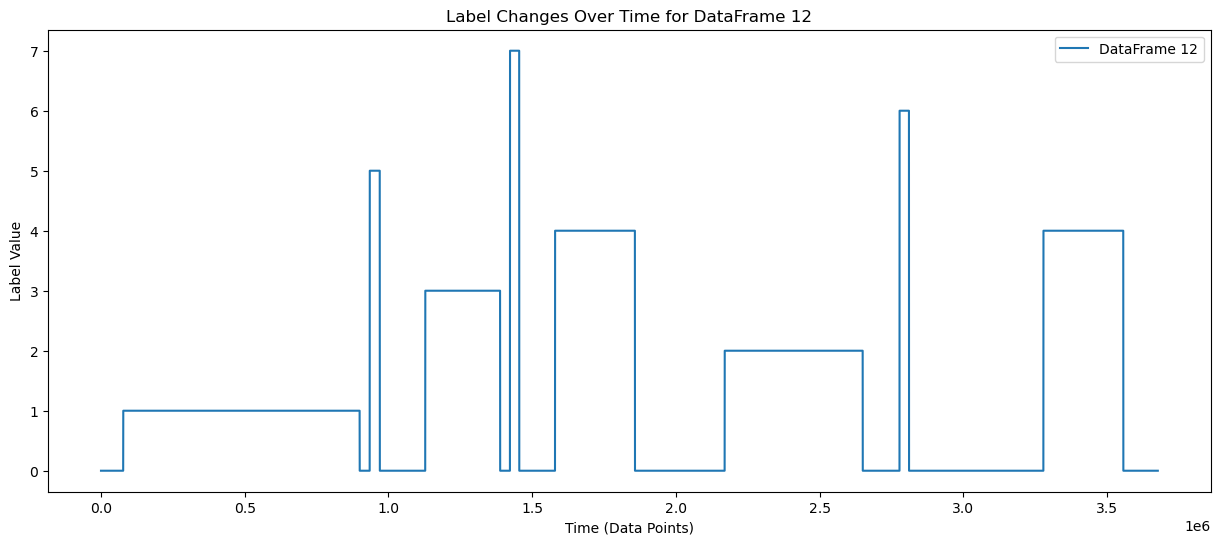

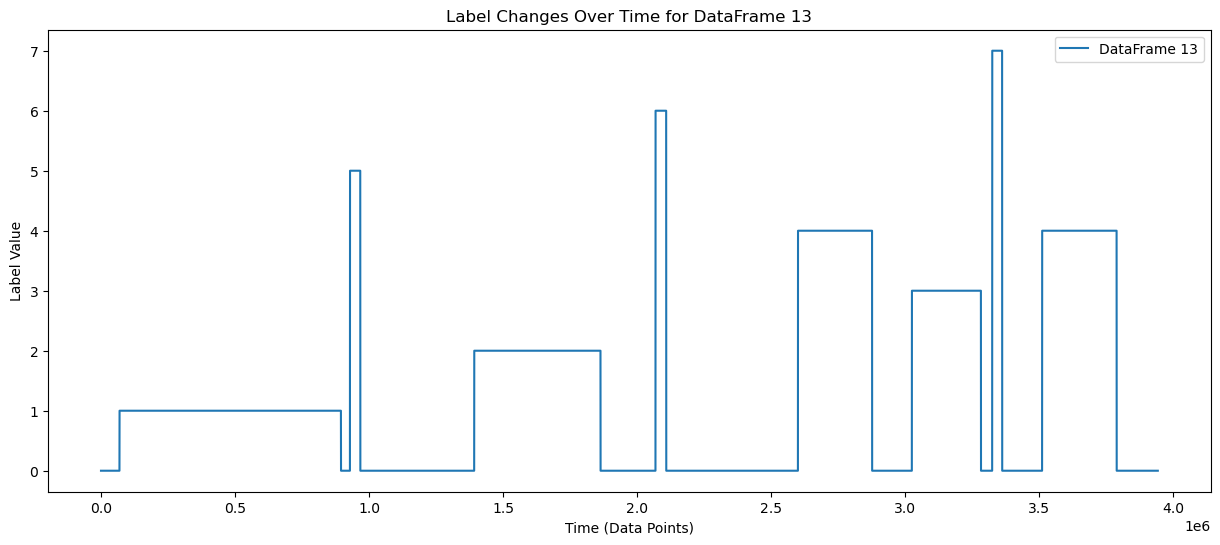

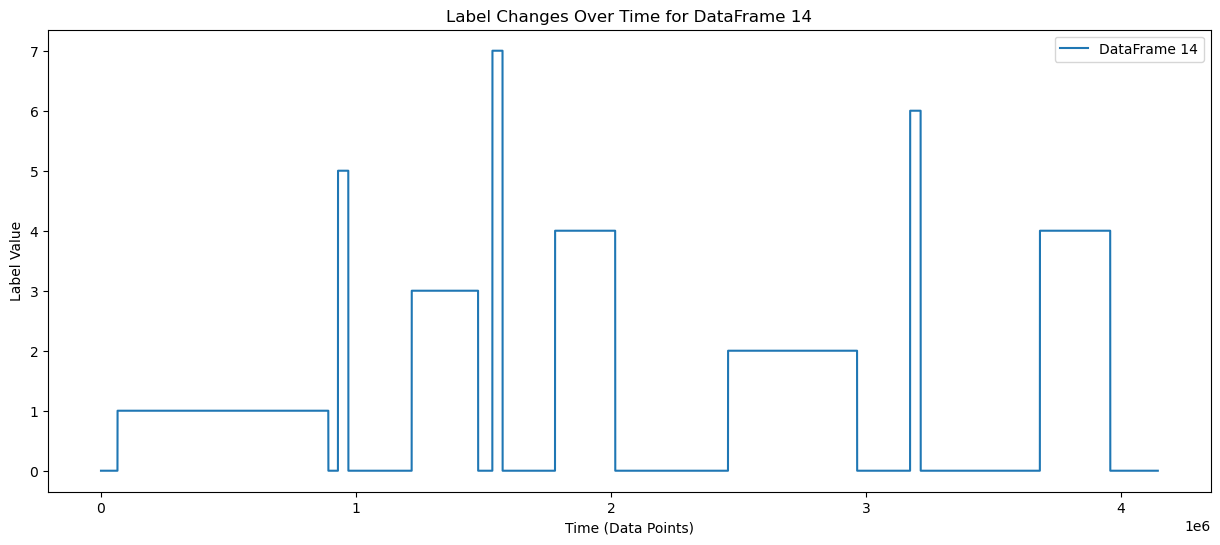

In [13]:
import matplotlib.pyplot as plt

for idx, df in enumerate(dfs):
    # Plotting
    plt.figure(figsize=(15,6))
    plt.plot(df['label'], label=f'DataFrame {idx}')
    plt.title(f'Label Changes Over Time for DataFrame {idx}')
    plt.xlabel('Time (Data Points)')
    plt.ylabel('Label Value')
    plt.yticks(df['label'].unique())  # Only show unique label values on the y-axis
    plt.legend()
    plt.show()

In [14]:
def compute_rmssd(rr_intervals):
    diff = np.diff(rr_intervals)
    return np.sqrt(np.mean(diff**2))

In [15]:
def compute_rolling_hrv(df, sampling_rate = 700, window_seconds = 60):
    out = ecg.ecg(signal=df['ECG'].values, sampling_rate = sampling_rate, show = False)
    r_peaks = out['rpeaks']
    
    rr_intervals = np.diff(r_peaks) / sampling_rate
    
    window_size = window_seconds * sampling_rate
    rolling_hrv = []
    for i in range(len(df)):
        start_idx = max(0, i - window_size)
        end_idx = i
        relevant_rr_intervals = rr_intervals[(r_peaks[:-1] >= start_idx) & (r_peaks[:-1] < end_idx)]
        
        if len(relevant_rr_intervals) > 1:
            rmssd = compute_rmssd(relevant_rr_intervals)
        else:
            rmssd = np.nan
            
        rolling_hrv.append(rmssd)
    
    return rolling_hrv

for i in range(len(dfs)):
    dfs[i]['Rolling_HRV'] = compute_rolling_hrv(dfs[i])

<Axes: >

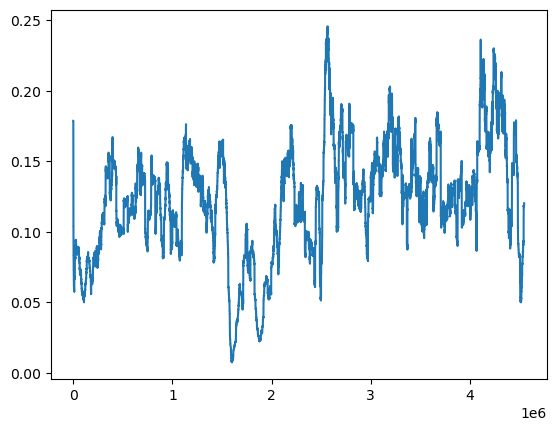

In [16]:
dfs[1]['Rolling_HRV'].plot()

<Axes: >

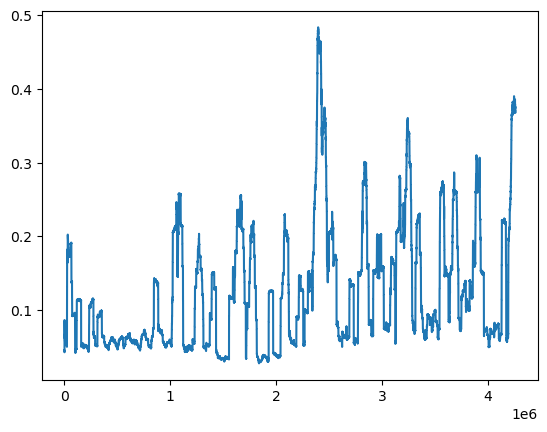

In [17]:
dfs[0]['Rolling_HRV'].plot()

<Axes: >

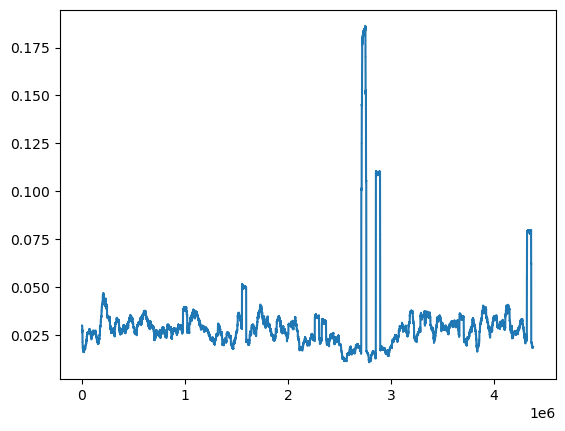

In [18]:
dfs[3]['Rolling_HRV'].plot()

<Axes: >

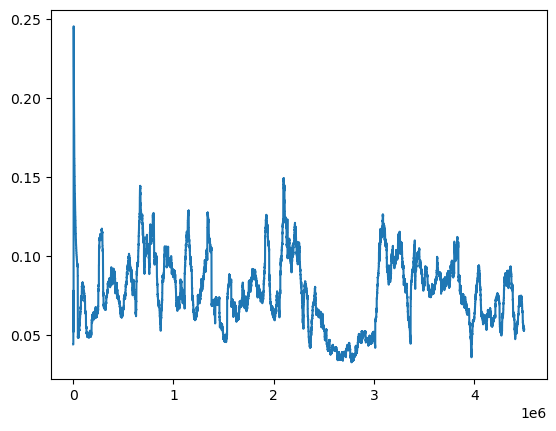

In [19]:
dfs[2]['Rolling_HRV'].plot()

<Axes: >

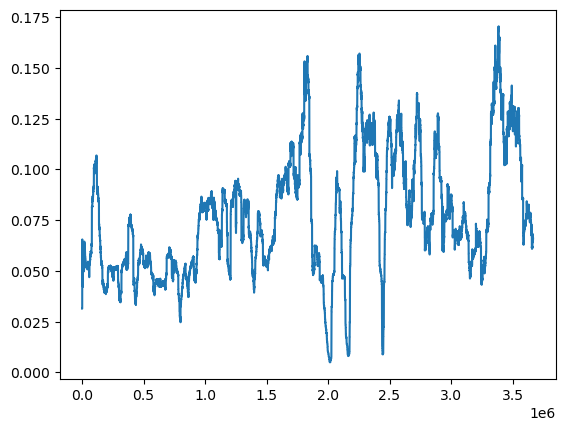

In [20]:
dfs[5]['Rolling_HRV'].plot()

In [21]:
# Define a function to normalize a single column
def normalize_column(column):
    return (column - column.mean()) / column.std()

# Normalize each feature within each dataframe
for df in dfs:
    for feature in ["ECG", "TEMP", "EDA", "Rolling_HRV"]:
        df[feature] = normalize_column(df[feature])

In [22]:
def downsample_dataframe(df, factor = 10):
    # Take the mean of numerical columns
    downsampled_df = df[['ECG', 'TEMP', 'EDA', 'Rolling_HRV']].groupby(df.index // factor).mean()
    
    # Take the first value for categorical columns
    downsampled_df['label'] = df['label'].iloc[::factor].values
    downsampled_df['subject'] = df['subject'].iloc[::factor].values
    
    return downsampled_df

In [23]:
def slice_into_chunks(df, chunk_size = 4200):
    number_of_chunks = len(df) // 4200
    chunks = []
    
    for i in range(number_of_chunks):
        chunk = df.iloc[i*chunk_size:(i+1)*chunk_size].copy()
        chunks.append(chunk)
        
    return chunks

downsampled_dfs = [downsample_dataframe(df) for df in dfs]

all_chunks = []
for df in downsampled_dfs:
    all_chunks.extend(slice_into_chunks(df))

In [24]:
len(all_chunks)

1442

In [25]:
filtered_chunks = []

for chunk in all_chunks:
    # Ensure the chunk has 4200 samples
    if len(chunk) != 4200:
        continue
        
    unique_labels = chunk['label'].unique()
    if len(unique_labels) != 1:
        continue
    
    if unique_labels[0] in [5, 6, 7]:
        continue
        
    filtered_chunks.append(chunk)
    
print(f"Total number of valid 1-minute chunks: {len(filtered_chunks)}")

Total number of valid 1-minute chunks: 1219


In [26]:
label_counts = {}

for chunk in filtered_chunks:
    label = chunk['label'].iloc[0]
    
    if label in label_counts:
        label_counts[label] += 1
        
    else:
        label_counts[label] = 1
        
print(label_counts)

{0: 536, 1: 282, 2: 152, 4: 170, 3: 79}


In [27]:
random.seed(42)

sampled_chunks = []
for label, count in label_counts.items():
    chunks_with_label = [chunk for chunk in filtered_chunks if chunk['label'].iloc[0] == label]
    sampled_chunks += random.sample(chunks_with_label, 79)
    
random.shuffle(sampled_chunks)

print(f"Total number of sampled chunks: {len(sampled_chunks)}")

Total number of sampled chunks: 395


In [28]:
sampled_chunks = [chunk.drop(columns=['subject'], inplace=False) for chunk in sampled_chunks]

In [29]:
sampled_chunks[4]

,ECG,TEMP,EDA,Rolling_HRV,label
268800,-0.095443,0.271974,0.125737,0.295382,4
268801,-0.095189,0.271974,0.125737,0.295382,4
268802,-0.046710,0.271974,0.125737,0.295382,4
268803,0.151360,0.271974,0.125737,0.295382,4
268804,0.214595,0.271974,0.125737,0.295382,4
...,...,...,...,...,...
272995,0.424085,0.251015,0.125737,0.286709,4
272996,0.666691,0.251015,0.125737,0.286709,4
272997,0.885849,0.251015,0.125737,0.286709,4
272998,1.026551,0.251015,0.125737,0.286709,4


In [30]:
for chunk in [sampled_chunks[55], sampled_chunks[72], sampled_chunks[126]]:
    chunk['Rolling_HRV'].fillna(method='bfill', inplace=True)  # or use 'bfill' for backward fill

In [31]:
X_list = [chunk.drop(columns = ['label']).values for chunk in sampled_chunks]
y_list = [chunk['label'].iloc[0] for chunk in sampled_chunks]

X = np.array(X_list)
y = np.array(y_list)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train_tensor = tf.convert_to_tensor(X_train, dtype = tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype = tf.int32)

X_val_tensor = tf.convert_to_tensor(X_val, dtype = tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype = tf.int32)

In [32]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
train_dataset = train_dataset.shuffle(buffer_size = len(X_train)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))
val_dataset = val_dataset.shuffle(buffer_size = len(X_val)).batch(BATCH_SIZE)

# Model Building

In [32]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    LSTM(128, input_shape = (4200, 4), return_sequences = True), 
    LSTM(64, return_sequences = False), 
    Dense(64, activation = 'relu'), 
    Dense(5, activation = 'softmax')
])

In [33]:
model.compile(optimizer = 'adam', 
             loss = 'sparse_categorical_crossentropy', 
             metrics = ['accuracy'])

epochs = 5

history = model.fit(train_dataset, validation_data = val_dataset, epochs = epochs)

Epoch 1/5
10/10 [==============================] - 63s 6s/step - loss: 1.4326 - accuracy: 0.4620 - val_loss: 1.2972 - val_accuracy: 0.4684
Epoch 2/5
10/10 [==============================] - 60s 6s/step - loss: 1.1953 - accuracy: 0.5158 - val_loss: 1.1890 - val_accuracy: 0.5063
Epoch 3/5
10/10 [==============================] - 49s 5s/step - loss: 1.0887 - accuracy: 0.5285 - val_loss: 1.2032 - val_accuracy: 0.5063
Epoch 4/5
10/10 [==============================] - 51s 5s/step - loss: 1.0406 - accuracy: 0.5538 - val_loss: 1.1502 - val_accuracy: 0.4557
Epoch 5/5
10/10 [==============================] - 56s 6s/step - loss: 1.0000 - accuracy: 0.5791 - val_loss: 1.1354 - val_accuracy: 0.4937


In [34]:
from tensorflow.keras.layers import Dropout, BatchNormalization, Input, Attention
from tensorflow.keras.regularizers import L1L2

model = Sequential()

# Input layer
model.add(Input(shape=(4200, 4)))

# LSTM layers with dropout and batch normalization
model.add(LSTM(128, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Optional: Attention mechanism
# model.add(Attention())

model.add(LSTM(64, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Dense layers with dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity.

In [36]:
epochs = 50  # Start with a larger number since early stopping is configured

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.7441 - accuracy: 0.2658 
Epoch 1: val_loss improved from inf to 5.26752, saving model to best_model_weights.h5
10/10 [==============================] - 103s 11s/step - loss: 5.7441 - accuracy: 0.2658 - val_loss: 5.2675 - val_accuracy: 0.4177
Epoch 2/50


/Users/wilsonbeckman/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 5.3441 - accuracy: 0.3070 
Epoch 2: val_loss improved from 5.26752 to 5.06327, saving model to best_model_weights.h5
10/10 [==============================] - 144s 15s/step - loss: 5.3441 - accuracy: 0.3070 - val_loss: 5.0633 - val_accuracy: 0.3797
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 4.9693 - accuracy: 0.3987 
Epoch 3: val_loss improved from 5.06327 to 4.84787, saving model to best_model_weights.h5
10/10 [==============================] - 117s 12s/step - loss: 4.9693 - accuracy: 0.3987 - val_loss: 4.8479 - val_accuracy: 0.3797
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 4.7991 - accuracy: 0.3956 
Epoch 4: val_loss improved from 4.84787 to 4.63938, saving model to best_model_weights.h5
10/10 [==============================] - 111s 11s/step - loss: 4.7991 - accuracy: 0.3956 - val_loss: 4.6394 - val_accuracy: 0.3544
Epoch 5/50
10/10 [==============================] - ETA: 0s - l

10/10 [==============================] - ETA: 0s - loss: 1.9672 - accuracy: 0.5253
Epoch 28: val_loss improved from 1.97504 to 1.89833, saving model to best_model_weights.h5
10/10 [==============================] - 75s 8s/step - loss: 1.9672 - accuracy: 0.5253 - val_loss: 1.8983 - val_accuracy: 0.5443
Epoch 29/50
10/10 [==============================] - ETA: 0s - loss: 1.9357 - accuracy: 0.5759
Epoch 29: val_loss did not improve from 1.89833
10/10 [==============================] - 75s 8s/step - loss: 1.9357 - accuracy: 0.5759 - val_loss: 1.9012 - val_accuracy: 0.5190
Epoch 30/50
10/10 [==============================] - ETA: 0s - loss: 1.9462 - accuracy: 0.5443
Epoch 30: val_loss did not improve from 1.89833
10/10 [==============================] - 75s 8s/step - loss: 1.9462 - accuracy: 0.5443 - val_loss: 1.9271 - val_accuracy: 0.5063
Epoch 31/50
10/10 [==============================] - ETA: 0s - loss: 1.8907 - accuracy: 0.5506
Epoch 31: val_loss improved from 1.89833 to 1.83996, savin

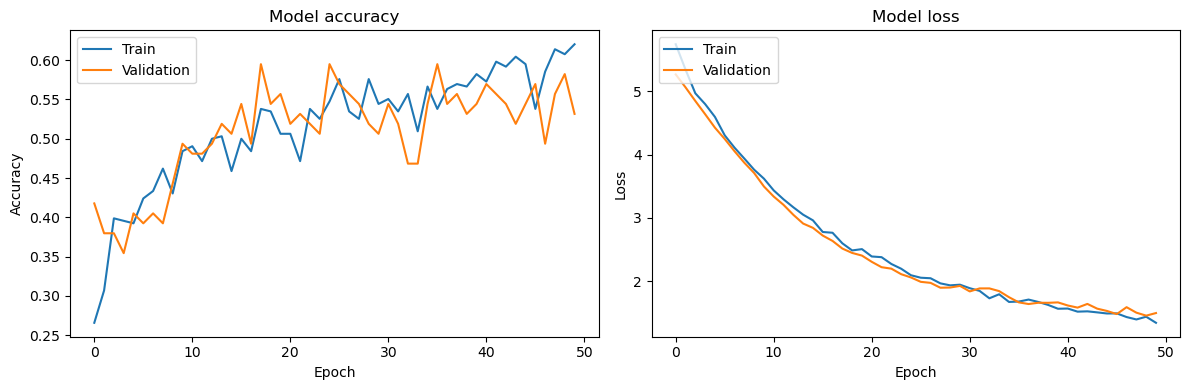

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Assuming test_dataset is prepared similarly to train_dataset and val_dataset
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 5s 1s/step - loss: 1.4982 - accuracy: 0.5316
Test Loss: 1.4982
Test Accuracy: 0.5316


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    #CNN layers for feature extraction
    model.add(Conv1D(64, kernel_size = 7, activation = 'relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.5))
    
    model.add(Conv1D(128, kernel_size = 5, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.4))
    
    #LSTM layer for sequence modeling
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    
    #Dense layers for classification
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    return model

input_shape = (4200, 4)
num_classes = 5

model = create_cnn_lstm_model(input_shape, num_classes)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4194, 64)          1856      
                                                                 
 batch_normalization_3 (Bat  (None, 4194, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 2097, 64)          0         
 D)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 2097, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2093, 128)         41088     
                                                                 
 batch_normalization_4 (Bat  (None, 2093, 128)        

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [41]:
epochs = 50  # Start with a larger number since early stopping is configured

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.4873
Epoch 1: val_loss improved from inf to 1.30378, saving model to best_model_weights.h5
10/10 [==============================] - 18s 2s/step - loss: 1.3541 - accuracy: 0.4873 - val_loss: 1.3038 - val_accuracy: 0.5190
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.0770 - accuracy: 0.5348
Epoch 2: val_loss improved from 1.30378 to 1.22523, saving model to best_model_weights.h5
10/10 [==============================] - 16s 2s/step - loss: 1.0770 - accuracy: 0.5348 - val_loss: 1.2252 - val_accuracy: 0.4684
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.9644 - accuracy: 0.6076
Epoch 3: val_loss improved from 1.22523 to 1.19007, saving model to best_model_weights.h5
10/10 [==============================] - 16s 2s/step - loss: 0.9644 - accuracy: 0.6076 - val_loss: 1.1901 - val_accuracy: 0.4810
Epoch 4/50
10/10 [==============================] - ETA: 0s - los

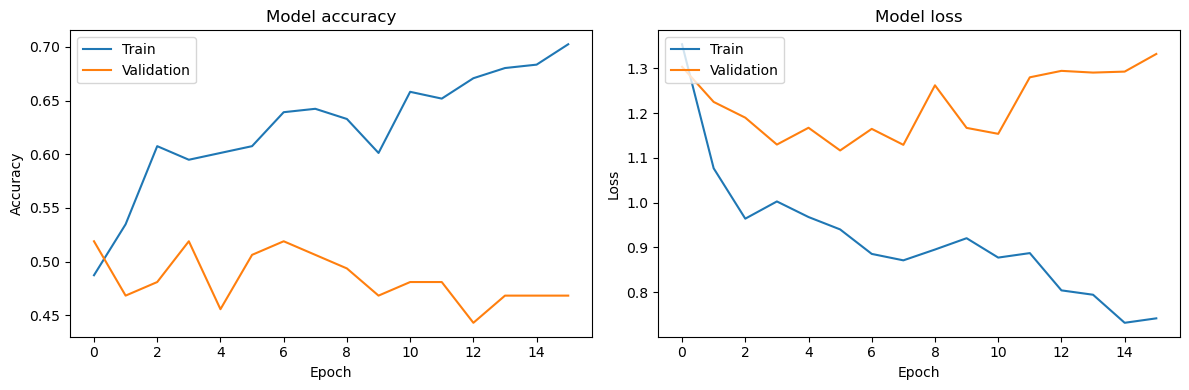

In [42]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Assuming test_dataset is prepared similarly to train_dataset and val_dataset
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 1s 337ms/step - loss: 1.1168 - accuracy: 0.5063
Test Loss: 1.1168
Test Accuracy: 0.5063


In [44]:
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

In [45]:
# Assuming `model` is your trained Keras model and `val_dataset` is your validation data
y_pred_probs = model.predict(val_dataset)

3/3 [==============================] - 1s 349ms/step


In [46]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.1803
Recall: 0.1615
F1 Score: 0.1600


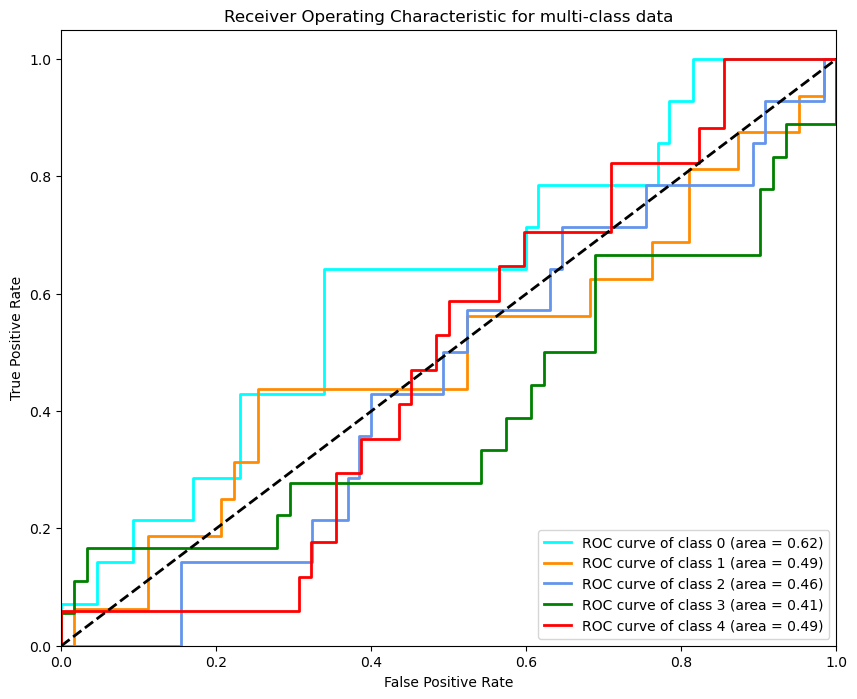

In [48]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: One-hot encode y_true if it isn't already
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Add your classes here

n_classes = y_true_one_hot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualize the results
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])  # Add more colors if you have many classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [49]:
from tensorflow.keras import layers, models

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout = 0.1):
    x = layers.LayerNormalization(epsilon = 1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim = head_size, num_heads = num_heads, dropout = dropout)(x, x)
    res = x + inputs
    
    x = layers.LayerNormalization(epsilon = 1e-6)(res)
    x = layers.Conv1D(filters = ff_dim, kernel_size = 1, activation = 'relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters = inputs.shape[-1], kernel_size = 1)(x)
    return x + res

def build_model(input_shape, num_classes, head_size = 64, num_heads = 4, ff_dim = 64, num_transformer_blocks = 4):
    inputs = tf.keras.Input(shape = input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation = 'softmax')(x)
    
    return models.Model(inputs, outputs)

input_shape = (4200, 4)
num_classes = 5

model = build_model(input_shape, num_classes)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 4200, 4)]            0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 4200, 4)              8         ['input_2[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 4200, 4)              4868      ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

 ltiHeadAttention)                                                  , 'layer_normalization_6[0][0]
                                                                    ']                            
                                                                                                  
 tf.__operators__.add_6 (TF  (None, 4200, 4)              0         ['multi_head_attention_3[0][0]
 OpLambda)                                                          ',                            
                                                                     'tf.__operators__.add_5[0][0]
                                                                    ']                            
                                                                                                  
 layer_normalization_7 (Lay  (None, 4200, 4)              8         ['tf.__operators__.add_6[0][0]
 erNormalization)                                                   ']                            
          

In [50]:
# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [1]:
EPOCHS = 50

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks = [checkpoint, early_stopping])

NameError: name 'model' is not defined

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers

def build_simple_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Conv1D Layer
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layer
    model.add(layers.LSTM(64, return_sequences=True))
    
    # GlobalMaxPooling1D Layer to reduce the dimensions before connecting to Dense Layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense Layer
    model.add(layers.Dense(64, activation='relu'))
    
    # Final Dense Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Assuming input_shape is (sequence_length, num_features) and num_classes is the number of categories you have
input_shape = (4200, 4)  # for example, 4200 timesteps and 4 features
num_classes = 5  # for example, 5 classes

model = build_simple_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4198, 64)          832       
                                                                 
 lstm (LSTM)                 (None, 4198, 64)          33024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 38341 (149.77 KB)
Trainable params: 38341 (149.77 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [36]:
EPOCHS = 50

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks = [checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.5056 - accuracy: 0.4272
Epoch 1: val_loss improved from inf to 1.44514, saving model to best_model_weights.h5
10/10 [==============================] - 20s 2s/step - loss: 1.5056 - accuracy: 0.4272 - val_loss: 1.4451 - val_accuracy: 0.4430
Epoch 2/50


/Users/wilsonbeckman/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.5158
Epoch 2: val_loss improved from 1.44514 to 1.27450, saving model to best_model_weights.h5
10/10 [==============================] - 19s 2s/step - loss: 1.2765 - accuracy: 0.5158 - val_loss: 1.2745 - val_accuracy: 0.4557
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.1365 - accuracy: 0.5316
Epoch 3: val_loss improved from 1.27450 to 1.20083, saving model to best_model_weights.h5
10/10 [==============================] - 28s 3s/step - loss: 1.1365 - accuracy: 0.5316 - val_loss: 1.2008 - val_accuracy: 0.4937
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.5506
Epoch 4: val_loss improved from 1.20083 to 1.16798, saving model to best_model_weights.h5
10/10 [==============================] - 17s 2s/step - loss: 1.0579 - accuracy: 0.5506 - val_loss: 1.1680 - val_accuracy: 0.5063
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.98

10/10 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.7595
Epoch 30: val_loss did not improve from 0.96775
10/10 [==============================] - 17s 2s/step - loss: 0.6056 - accuracy: 0.7595 - val_loss: 1.0143 - val_accuracy: 0.5696
Epoch 31/50
10/10 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.7500
Epoch 31: val_loss did not improve from 0.96775
10/10 [==============================] - 18s 2s/step - loss: 0.5930 - accuracy: 0.7500 - val_loss: 1.0670 - val_accuracy: 0.6203
Epoch 32/50
10/10 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.7848
Epoch 32: val_loss did not improve from 0.96775
10/10 [==============================] - 25s 2s/step - loss: 0.5683 - accuracy: 0.7848 - val_loss: 1.0350 - val_accuracy: 0.6329
Epoch 33/50
10/10 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7848
Epoch 33: val_loss did not improve from 0.96775
10/10 [==============================] - 20s 2s/step 

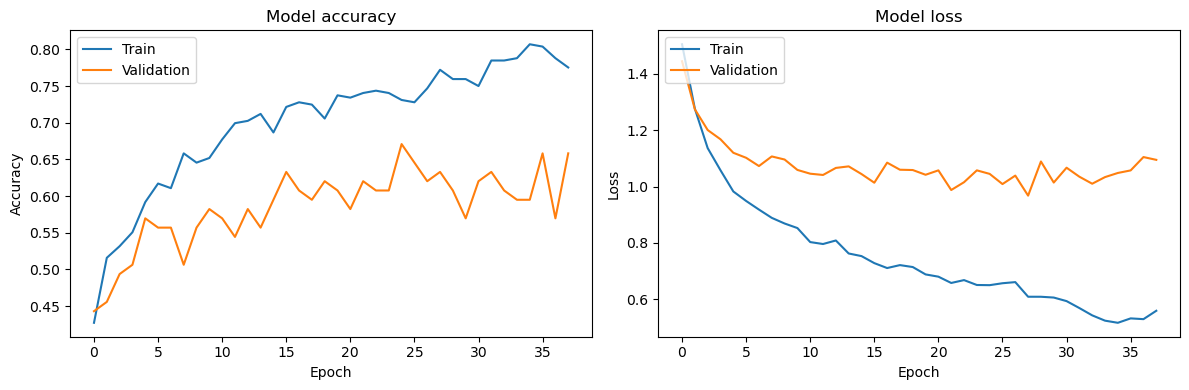

In [37]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Assuming test_dataset is prepared similarly to train_dataset and val_dataset
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 1s 198ms/step - loss: 0.9677 - accuracy: 0.6329
Test Loss: 0.9677
Test Accuracy: 0.6329


In [39]:
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

In [40]:
# Assuming `model` is your trained Keras model and `val_dataset` is your validation data
y_pred_probs = model.predict(val_dataset)

3/3 [==============================] - 1s 200ms/step


In [41]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2752
Recall: 0.2765
F1 Score: 0.2744


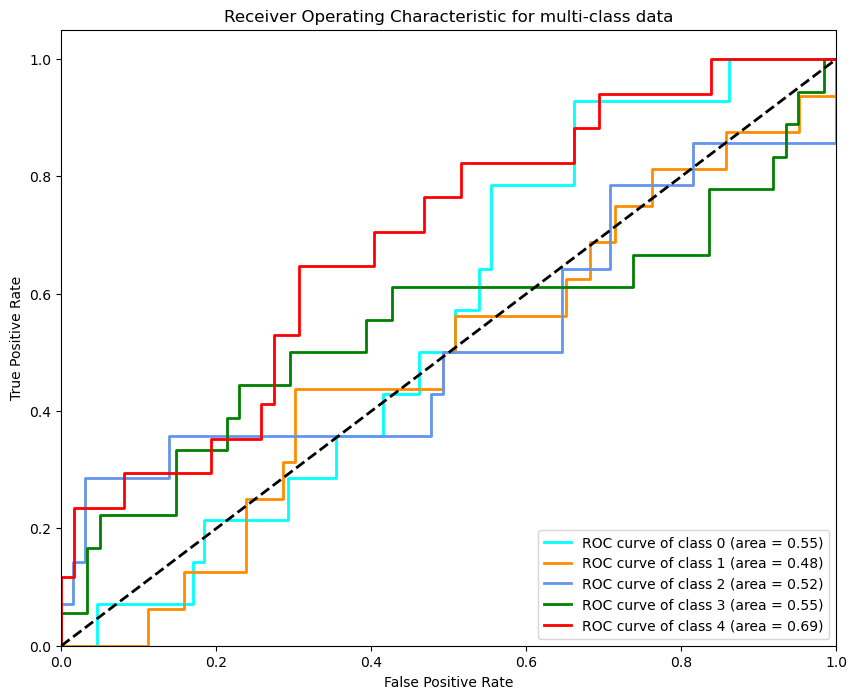

In [43]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: One-hot encode y_true if it isn't already
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Add your classes here

n_classes = y_true_one_hot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualize the results
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])  # Add more colors if you have many classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [56]:
def build_regularized_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Conv1D Layer
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    # LSTM Layer
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    # GlobalMaxPooling1D Layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense Layer
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    
    # Final Dense Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [57]:
# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [58]:
# Define the model
model = build_regularized_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, 
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.5081 - accuracy: 0.4051
Epoch 1: val_loss improved from inf to 1.54952, saving model to best_model_weights.h5
10/10 [==============================] - 20s 2s/step - loss: 1.5081 - accuracy: 0.4051 - val_loss: 1.5495 - val_accuracy: 0.3797
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.1559 - accuracy: 0.5665
Epoch 2: val_loss improved from 1.54952 to 1.52939, saving model to best_model_weights.h5
10/10 [==============================] - 17s 2s/step - loss: 1.1559 - accuracy: 0.5665 - val_loss: 1.5294 - val_accuracy: 0.3544
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.5823
Epoch 3: val_loss improved from 1.52939 to 1.52169, saving model to best_model_weights.h5
10/10 [==============================] - 17s 2s/step - loss: 1.0824 - accuracy: 0.5823 - val_loss: 1.5217 - val_accuracy: 0.3165
Epoch 4/50
10/10 [==============================] - ETA: 0s - los

In [59]:
import tensorflow as tf
from tensorflow.keras import models, layers

def build_simple_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Conv1D Layer
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layer
    model.add(layers.LSTM(128, return_sequences=True))
    
    # GlobalMaxPooling1D Layer to reduce the dimensions before connecting to Dense Layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense Layer
    model.add(layers.Dense(64, activation='relu'))
    
    # Final Dense Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Assuming input_shape is (sequence_length, num_features) and num_classes is the number of categories you have
input_shape = (4200, 4)  # for example, 4200 timesteps and 4 features
num_classes = 5  # for example, 5 classes

model = build_simple_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 4198, 128)         1664      
                                                                 
 lstm_7 (LSTM)               (None, 4198, 128)         131584    
                                                                 
 global_max_pooling1d_7 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 5)                 325       
                                                                 
Total params: 141829 (554.02 KB)
Trainable params: 141829 (554.02 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [61]:
EPOCHS = 50

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks = [checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.4146
Epoch 1: val_loss improved from inf to 1.38037, saving model to best_model_weights.h5
10/10 [==============================] - 38s 4s/step - loss: 1.5031 - accuracy: 0.4146 - val_loss: 1.3804 - val_accuracy: 0.4177
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.5443
Epoch 2: val_loss improved from 1.38037 to 1.21392, saving model to best_model_weights.h5
10/10 [==============================] - 37s 4s/step - loss: 1.1974 - accuracy: 0.5443 - val_loss: 1.2139 - val_accuracy: 0.4937
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.5411
Epoch 3: val_loss improved from 1.21392 to 1.19128, saving model to best_model_weights.h5
10/10 [==============================] - 37s 4s/step - loss: 1.0610 - accuracy: 0.5411 - val_loss: 1.1913 - val_accuracy: 0.4937
Epoch 4/50
10/10 [==============================] - ETA: 0s - los

10/10 [==============================] - 36s 4s/step - loss: 0.6965 - accuracy: 0.6994 - val_loss: 1.0718 - val_accuracy: 0.5443
Epoch 30/50
10/10 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.7247
Epoch 30: val_loss did not improve from 0.92360
10/10 [==============================] - 35s 4s/step - loss: 0.7492 - accuracy: 0.7247 - val_loss: 1.0618 - val_accuracy: 0.5696
Epoch 31/50
10/10 [==============================] - ETA: 0s - loss: 0.7352 - accuracy: 0.6994
Epoch 31: val_loss did not improve from 0.92360
10/10 [==============================] - 35s 4s/step - loss: 0.7352 - accuracy: 0.6994 - val_loss: 1.0792 - val_accuracy: 0.5443
Epoch 32/50
10/10 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.7247
Epoch 32: val_loss did not improve from 0.92360
10/10 [==============================] - 37s 4s/step - loss: 0.6793 - accuracy: 0.7247 - val_loss: 0.9855 - val_accuracy: 0.5823
Epoch 33/50
10/10 [==============================] - ET

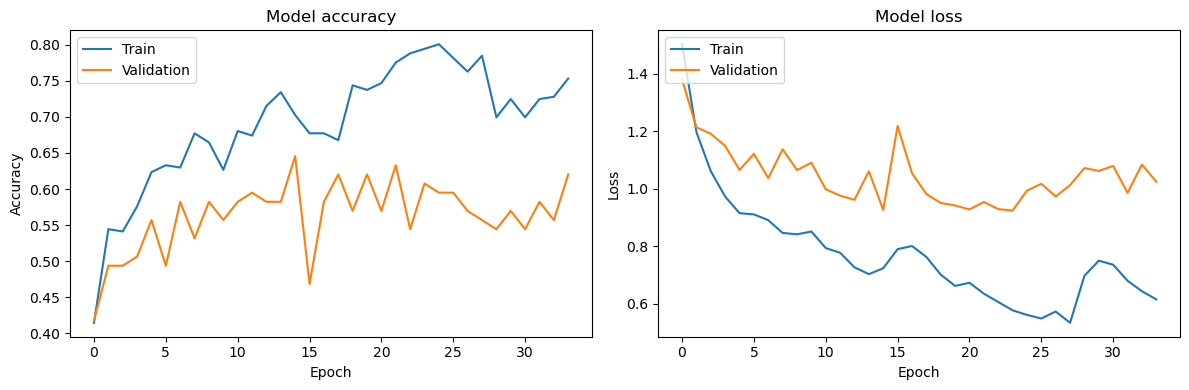

In [62]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [63]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Assuming test_dataset is prepared similarly to train_dataset and val_dataset
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 2s 662ms/step - loss: 0.9236 - accuracy: 0.6076
Test Loss: 0.9236
Test Accuracy: 0.6076


In [64]:
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

In [65]:
# Assuming `model` is your trained Keras model and `val_dataset` is your validation data
y_pred_probs = model.predict(val_dataset)

3/3 [==============================] - 2s 741ms/step


In [66]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [67]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2388
Recall: 0.2290
F1 Score: 0.2316


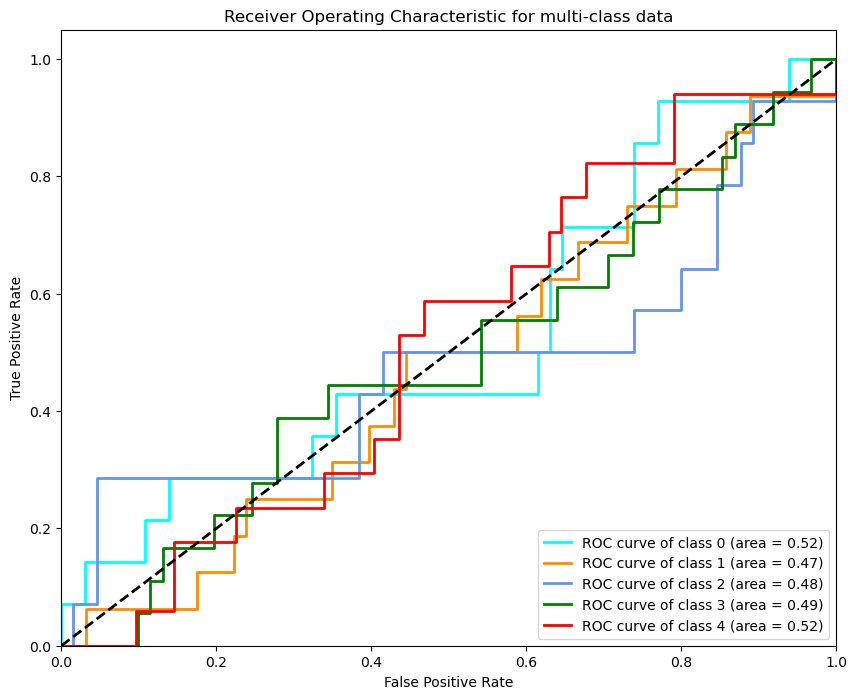

In [68]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: One-hot encode y_true if it isn't already
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Add your classes here

n_classes = y_true_one_hot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualize the results
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])  # Add more colors if you have many classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [69]:
import tensorflow as tf
from tensorflow.keras import models, layers

def build_simple_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Conv1D Layer
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # LSTM Layer
    model.add(layers.LSTM(256, return_sequences=True))
    
    # GlobalMaxPooling1D Layer to reduce the dimensions before connecting to Dense Layer
    model.add(layers.GlobalMaxPooling1D())
    
    # Dense Layer
    model.add(layers.Dense(128, activation='relu'))
    
    # Final Dense Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Assuming input_shape is (sequence_length, num_features) and num_classes is the number of categories you have
input_shape = (4200, 4)  # for example, 4200 timesteps and 4 features
num_classes = 5  # for example, 5 classes

model = build_simple_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 4198, 256)         3328      
                                                                 
 lstm_8 (LSTM)               (None, 4198, 256)         525312    
                                                                 
 global_max_pooling1d_8 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 562181 (2.14 MB)
Trainable params: 562181 (2.14 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Configure checkpoints to save best model weights
checkpoint = ModelCheckpoint('best_model_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Configure early stopping to stop training if no improvement
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,  # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True)

In [71]:
EPOCHS = 50

history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks = [checkpoint, early_stopping])

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.3517 - accuracy: 0.4905
Epoch 1: val_loss improved from inf to 1.23816, saving model to best_model_weights.h5
10/10 [==============================] - 71s 7s/step - loss: 1.3517 - accuracy: 0.4905 - val_loss: 1.2382 - val_accuracy: 0.4937
Epoch 2/50


/Users/wilsonbeckman/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 1.0794 - accuracy: 0.5570
Epoch 2: val_loss improved from 1.23816 to 1.20603, saving model to best_model_weights.h5
10/10 [==============================] - 68s 7s/step - loss: 1.0794 - accuracy: 0.5570 - val_loss: 1.2060 - val_accuracy: 0.4937
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.5886
Epoch 3: val_loss improved from 1.20603 to 1.15063, saving model to best_model_weights.h5
10/10 [==============================] - 66s 7s/step - loss: 0.9718 - accuracy: 0.5886 - val_loss: 1.1506 - val_accuracy: 0.4684
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.9397 - accuracy: 0.5981
Epoch 4: val_loss improved from 1.15063 to 1.09891, saving model to best_model_weights.h5
10/10 [==============================] - 67s 7s/step - loss: 0.9397 - accuracy: 0.5981 - val_loss: 1.0989 - val_accuracy: 0.5443
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.89

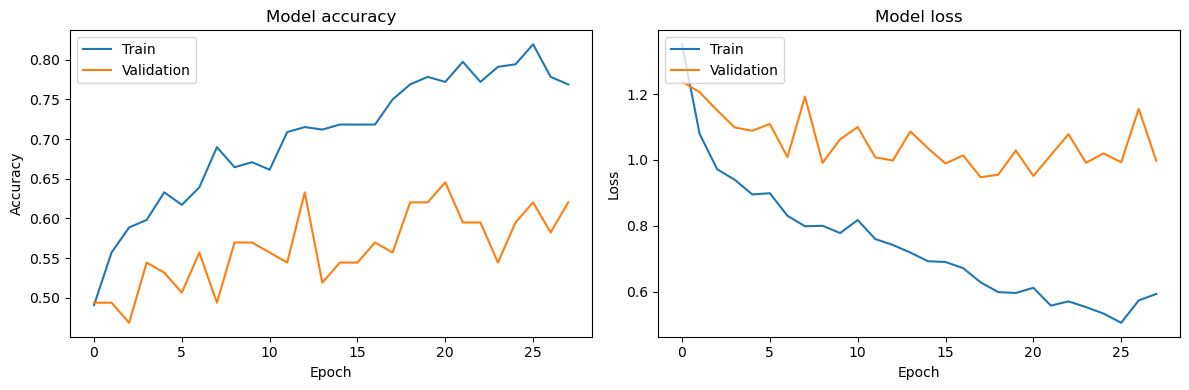

In [72]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [73]:
test_loss, test_accuracy = model.evaluate(val_dataset)  # Assuming test_dataset is prepared similarly to train_dataset and val_dataset
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 5s 2s/step - loss: 0.9477 - accuracy: 0.5570
Test Loss: 0.9477
Test Accuracy: 0.5570


In [74]:
y_true = []
for _, labels in val_dataset:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

In [75]:
# Assuming `model` is your trained Keras model and `val_dataset` is your validation data
y_pred_probs = model.predict(val_dataset)

3/3 [==============================] - 5s 1s/step


In [76]:
y_pred = np.argmax(y_pred_probs, axis=1)

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.2026
Recall: 0.2047
F1 Score: 0.2018


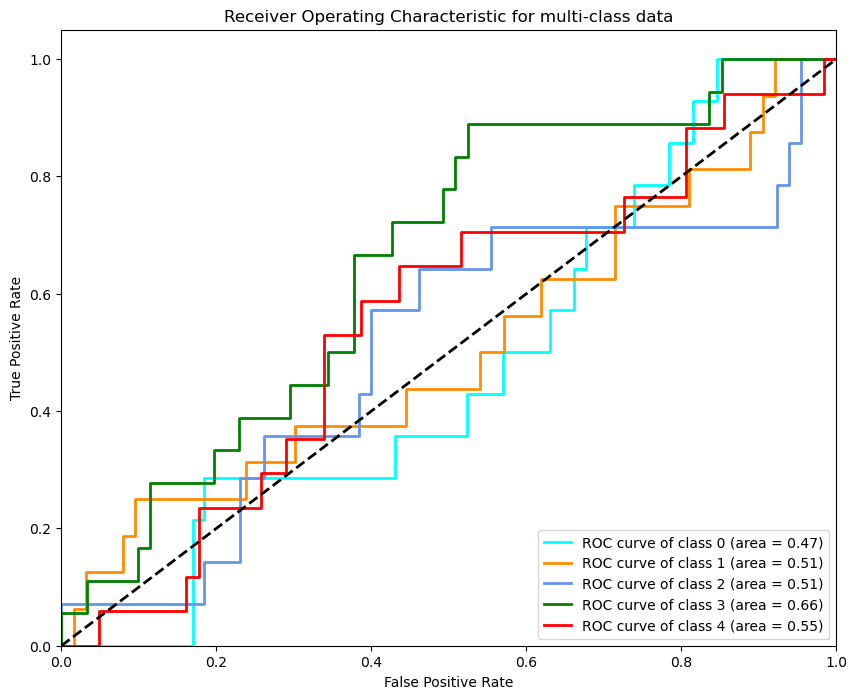

In [78]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Step 1: One-hot encode y_true if it isn't already
y_true_one_hot = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # Add your classes here

n_classes = y_true_one_hot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualize the results
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])  # Add more colors if you have many classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()